# 🔬 Adaptive Query Projection with Residual Adapters

## Comparing Standard vs Adaptive Domain Alignment

This notebook demonstrates **two query projection strategies** in ScAdver:

1. **Standard Projection** (`transform_query()`) - Fast, zero-shot
2. **Adaptive Projection** (`transform_query_adaptive()`) - Slower, domain adaptation

**When to use adaptive:**
- Large domain shift (e.g., 10X → Smart-seq2)
- Different tissue types or experimental conditions
- Quality matters more than speed

**When to use standard:**
- Similar protocols
- Processing many batches (speed critical)
- Real-time applications

In [9]:
# Import libraries
import numpy as np
import scanpy as sc
import torch
import matplotlib.pyplot as plt
import time
from sklearn.metrics import silhouette_score, adjusted_rand_score
import pandas as pd

from scadver import adversarial_batch_correction, transform_query, transform_query_adaptive

print("✅ Libraries imported successfully!")
print(f"📦 Scanpy version: {sc.__version__}")
print(f"🔥 PyTorch version: {torch.__version__}")
print(f"🖥️  Device: {'MPS' if torch.backends.mps.is_available() else 'CPU'}")

✅ Libraries imported successfully!
📦 Scanpy version: 1.11.4
🔥 PyTorch version: 2.8.0
🖥️  Device: MPS


## 📊 Step 1: Load Pancreas Dataset with Domain Shift

We'll use the real pancreas dataset with:
- **Reference**: 10X-based protocols (celseq, celseq2, fluidigmc1)
- **Query**: Smart-seq2 (full-length transcriptomics - different technology with domain shift)

In [10]:
# Load pancreas dataset
print("🔬 Loading pancreas dataset...")

adata = sc.read("human_pancreas_norm_complexBatch.h5ad")

print(f"✅ Loaded dataset: {adata.shape[0]} cells × {adata.shape[1]} genes")
print(f"📊 Technologies: {adata.obs['tech'].unique()}")
print(f"🧬 Cell types: {adata.obs['celltype'].unique()}")

# Preprocess - select highly variable genes
print("\n🔄 Preprocessing data...")
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="tech", subset=True)
print(f"✅ Selected {adata.shape[1]} highly variable genes")

# Split into reference and query
# Reference: celseq, celseq2, fluidigmc1 (10X-based protocols)
reference_techs = ['celseq', 'celseq2', 'fluidigmc1']
adata_ref = adata[adata.obs['tech'].isin(reference_techs)].copy()

# Query: smartseq2 (full-length sequencing - DOMAIN SHIFT!)
adata_query = adata[adata.obs['tech'] == 'smartseq2'].copy()

print(f"\n📊 Data Split:")
print(f"   Reference: {adata_ref.shape[0]} cells ({', '.join(reference_techs)})")
print(f"   Technologies: {adata_ref.obs['tech'].value_counts().to_dict()}")
print(f"\n   Query: {adata_query.shape[0]} cells (smartseq2 - DOMAIN SHIFT)")
print(f"\n🧬 Cell type distribution in reference:")
print(adata_ref.obs['celltype'].value_counts())
print(f"\n🧬 Cell type distribution in query:")
print(adata_query.obs['celltype'].value_counts())

🔬 Loading pancreas dataset...
✅ Loaded dataset: 16382 cells × 19093 genes
📊 Technologies: ['celseq', 'celseq2', 'fluidigmc1', 'smartseq2', 'inDrop1', 'inDrop2', 'inDrop3', 'inDrop4', 'smarter']
Categories (9, object): ['celseq', 'celseq2', 'fluidigmc1', 'inDrop1', ..., 'inDrop3', 'inDrop4', 'smarter', 'smartseq2']
🧬 Cell types: ['gamma', 'acinar', 'alpha', 'delta', 'beta', ..., 'mast', 'macrophage', 'epsilon', 'quiescent_stellate', 't_cell']
Length: 14
Categories (14, object): ['acinar', 'activated_stellate', 'alpha', 'beta', ..., 'mast', 'quiescent_stellate', 'schwann', 't_cell']

🔄 Preprocessing data...
✅ Selected 2000 highly variable genes

📊 Data Split:
   Reference: 3927 cells (celseq, celseq2, fluidigmc1)
   Technologies: {'celseq2': 2285, 'celseq': 1004, 'fluidigmc1': 638}

   Query: 2394 cells (smartseq2 - DOMAIN SHIFT)

🧬 Cell type distribution in reference:
celltype
alpha                 1273
beta                   864
ductal                 621
acinar                 523
del

## 🏋️ Step 2: Train ScAdver on Reference Data

In [12]:
%%time
# Train on reference data
adata_ref_corrected, model, ref_metrics = adversarial_batch_correction(
    adata=adata_ref,
    bio_label='celltype',
    batch_label='tech',
    latent_dim=256,
    epochs=50,
    device='mps',
    bio_weight=20.0
)

print(f"\n✅ Reference training complete!")
print(f"   Biology preservation: {ref_metrics['biology_preservation']:.4f}")
print(f"   Batch correction: {ref_metrics['batch_correction']:.4f}")
print(f"   Overall score: {ref_metrics['overall_score']:.4f}")

🚀 ADVERSARIAL BATCH CORRECTION
   Device: mps
📊 DATA PREPARATION:
   Valid samples: 3927/3927
   Input shape: (3927, 2000)
   Biology labels: 13 unique
   Batch labels: 3 unique
   Standard batch correction (no reference-query split)
🧠 MODEL ARCHITECTURE:
   Input dimension: 2000
   Latent dimension: 256
   Biology classes: 13
   Batch classes: 3
🏋️ TRAINING MODEL:
   Epochs: 50
   Learning rate: 0.001
   Bio weight: 20.0
   Batch weight: 0.5
✅ Training completed! Best biology accuracy: 0.000
🔄 GENERATING CORRECTED EMBEDDING:
   Output embedding shape: (3927, 256)
   💡 Tip: Set return_reconstructed=True to get batch-corrected gene expression matrix
📊 CALCULATING PERFORMANCE METRICS:


/opt/miniconda3/envs/single_cell/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/single_cell/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/single_cell/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/single_cell/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/single_cell/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/single_cell/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


   Biology preservation: 0.4733
   Batch correction: 0.9771
   Overall score: 0.6748
🎉 ADVERSARIAL BATCH CORRECTION COMPLETE!
   Latent embedding: adata_corrected.obsm['X_ScAdver'] (shape: (3927, 256))

✅ Reference training complete!
   Biology preservation: 0.4733
   Batch correction: 0.9771
   Overall score: 0.6748
CPU times: user 23.5 s, sys: 3.17 s, total: 26.7 s
Wall time: 25.9 s


## 🚀 Step 3: Project Query Data - Compare Methods

### Method 1: Standard Projection (Fast)

In [13]:
%%time
# Standard projection (fast, zero-shot)
adata_query_standard = transform_query(model, adata_query, device='mps')

🚀 TRANSFORMING QUERY DATA (No Retraining)
   Device: mps
   Query samples: 2394
   Query features: 2000
🔄 Projecting through frozen encoder...
   ✅ Encoder weights: FROZEN (no training)
   ✅ Batch correction: Active (via learned transformation)
   ✅ Biology preservation: Active (via learned transformation)
✅ Transformation complete!
   Output embedding shape: (2394, 256)

📊 How Batch Correction Works Without Retraining:
   1. Encoder learned transformation: X (genes) → Z (latent)
   2. During training, Z was optimized to:
      • Preserve biology (bio_classifier succeeds)
      • Remove batch effects (batch_discriminator fails)
   3. This transformation is now FIXED in the encoder weights
   4. New query data passes through same transformation
   5. Result: Batch-corrected, biology-preserved embeddings!
CPU times: user 16.1 ms, sys: 14.7 ms, total: 30.8 ms
Wall time: 55.8 ms


### Method 2: Adaptive Projection (Domain Adaptation)

In [20]:
%%time
# Adaptive projection (slower, domain adaptation with residual adapter)
adata_query_adaptive = transform_query_adaptive(
    model=model,
    adata_query=adata_query,
    adata_reference=adata_ref,  # Use full reference for better adaptation
    bio_label='celltype',
    adapter_dim=128,
    adaptation_epochs=30,
    device='mps'
)

🔬 ADAPTIVE QUERY PROJECTION (Domain Adaptation)
   Device: mps
   Query samples: 2394
   Adapter dimension: 128
   Adaptation epochs: 30
   Reference samples for alignment: 3927
   Biological supervision: celltype (13 classes)

🏋️  Training residual adapter...
   Strategy: Adversarial domain alignment + biological preservation
   Epoch 1/30 - Disc: 1.4123, Adapter: 7.3051
   Epoch 10/30 - Disc: 0.6515, Adapter: 4.5989
   Epoch 20/30 - Disc: 0.4789, Adapter: 4.9848
   Epoch 30/30 - Disc: 0.5620, Adapter: 4.8583
✅ Adaptation complete! Best alignment loss: 4.5989

🔄 Generating adapted embeddings...
   ✅ Adapted embedding: (2394, 256)

🎉 ADAPTIVE PROJECTION COMPLETE!
   Output: adata.obsm['X_ScAdver'] (adapted embeddings)
CPU times: user 4.59 s, sys: 775 ms, total: 5.36 s
Wall time: 5.31 s


## 📊 Step 4: Calculate Evaluation Metrics

We'll compute metrics for:
1. **Batch Correction**: Silhouette score on batch labels (lower = better mixing)
2. **Biology Preservation**: Silhouette score on cell types (higher = better separation)
3. **Cell Type Accuracy**: How well cell types cluster together

In [21]:
def calculate_metrics(adata, name):
    """Calculate batch correction and biology preservation metrics"""
    embeddings = adata.obsm['X_ScAdver']
    batches = adata.obs['tech'].values
    celltypes = adata.obs['celltype'].values
    
    # Batch correction: lower is better (batches should mix)
    batch_sil = silhouette_score(embeddings, batches)
    
    # Biology preservation: higher is better (cell types should separate)
    bio_sil = silhouette_score(embeddings, celltypes)
    
    # Cell type purity using ARI
    from sklearn.cluster import KMeans
    n_clusters = len(np.unique(celltypes))
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(embeddings)
    ari = adjusted_rand_score(celltypes, cluster_labels)
    
    # Combined score (maximize bio, minimize batch)
    combined_score = bio_sil - batch_sil
    
    return {
        'name': name,
        'batch_silhouette': batch_sil,
        'bio_silhouette': bio_sil,
        'ari_celltype': ari,
        'combined_score': combined_score
    }

# Calculate for each method
print("📊 Calculating metrics...\n")

# Reference only
metrics_ref = calculate_metrics(adata_ref_corrected, 'Reference Only')

# Combined: Reference + Standard Query
adata_ref_corrected.obs['method'] = 'Reference'
adata_query_standard.obs['method'] = 'Query'
adata_combined_standard = sc.concat([adata_ref_corrected, adata_query_standard])
metrics_standard = calculate_metrics(adata_combined_standard, 'Standard Projection')

# Combined: Reference + Adaptive Query
adata_query_adaptive.obs['method'] = 'Query'
adata_combined_adaptive = sc.concat([adata_ref_corrected, adata_query_adaptive])
metrics_adaptive = calculate_metrics(adata_combined_adaptive, 'Adaptive Projection')

# Create comparison DataFrame
metrics_df = pd.DataFrame([metrics_ref, metrics_standard, metrics_adaptive])
metrics_df = metrics_df.set_index('name')

print("="*70)
print("EVALUATION METRICS")
print("="*70)
print(metrics_df.to_string())
print("\n💡 Interpretation:")
print("   • Batch Silhouette: LOWER = better mixing (target: close to 0)")
print("   • Bio Silhouette: HIGHER = better separation (target: close to 1)")
print("   • ARI Cell Type: HIGHER = better clustering (target: close to 1)")
print("   • Combined Score: HIGHER = better overall (bio - batch)")
print("="*70)

📊 Calculating metrics...



/opt/miniconda3/envs/single_cell/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/single_cell/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/single_cell/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/single_cell/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/single_cell/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/single_cell/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/single_cell/lib/python3.12/site-package

EVALUATION METRICS
                     batch_silhouette  bio_silhouette  ari_celltype  combined_score
name                                                                               
Reference Only               0.045792       -0.053477      0.325992       -0.099269
Standard Projection         -0.021417        0.002598      0.339037        0.024015
Adaptive Projection          0.119540       -0.040039      0.231490       -0.159579

💡 Interpretation:
   • Batch Silhouette: LOWER = better mixing (target: close to 0)
   • Bio Silhouette: HIGHER = better separation (target: close to 1)
   • ARI Cell Type: HIGHER = better clustering (target: close to 1)
   • Combined Score: HIGHER = better overall (bio - batch)


## 📈 Step 5: Visualize Comparison

Create UMAP visualizations showing:
1. Projection method (reference vs standard vs adaptive)
2. Cell types (biological signal)
3. Technical batches (batch effects)

/opt/miniconda3/envs/single_cell/lib/python3.12/site-packages/anndata/_core/anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


🔄 Computing UMAP...
✅ UMAP computed!


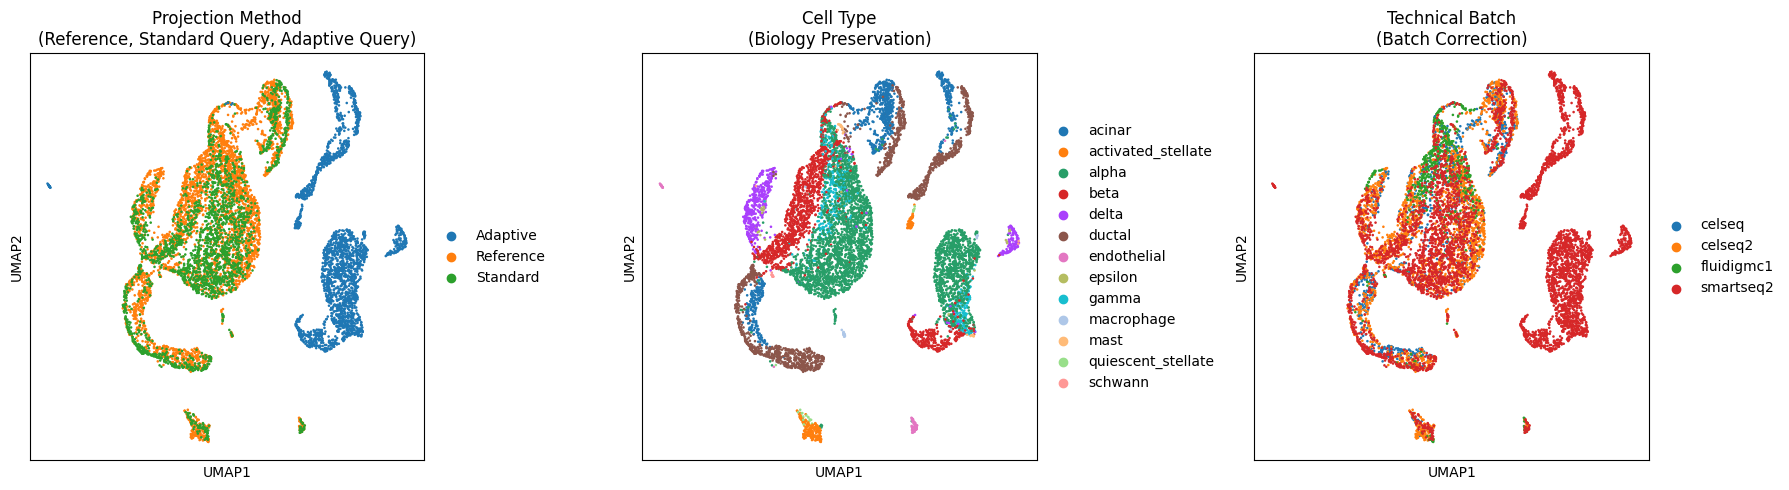


✅ Visualization complete!


In [22]:
# Prepare combined dataset
adata_ref_corrected.obs['projection'] = 'Reference'
adata_query_standard.obs['projection'] = 'Standard'
adata_query_adaptive.obs['projection'] = 'Adaptive'

adata_all = sc.concat([
    adata_ref_corrected,
    adata_query_standard,
    adata_query_adaptive
])

# Compute UMAP
print("🔄 Computing UMAP...")
sc.pp.neighbors(adata_all, use_rep='X_ScAdver', n_neighbors=15)
sc.tl.umap(adata_all)
print("✅ UMAP computed!")

# Create visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sc.pl.umap(adata_all, color='projection', ax=axes[0], show=False, 
           title='Projection Method\n(Reference, Standard Query, Adaptive Query)', 
           palette=['#1f77b4', '#ff7f0e', '#2ca02c'])

sc.pl.umap(adata_all, color='celltype', ax=axes[1], show=False,
           title='Cell Type\n(Biology Preservation)')

sc.pl.umap(adata_all, color='tech', ax=axes[2], show=False,
           title='Technical Batch\n(Batch Correction)')

plt.tight_layout()
plt.show()

print("\n✅ Visualization complete!")

## 📊 Step 6: Detailed Metrics Visualization

Compare metrics side-by-side with bar plots

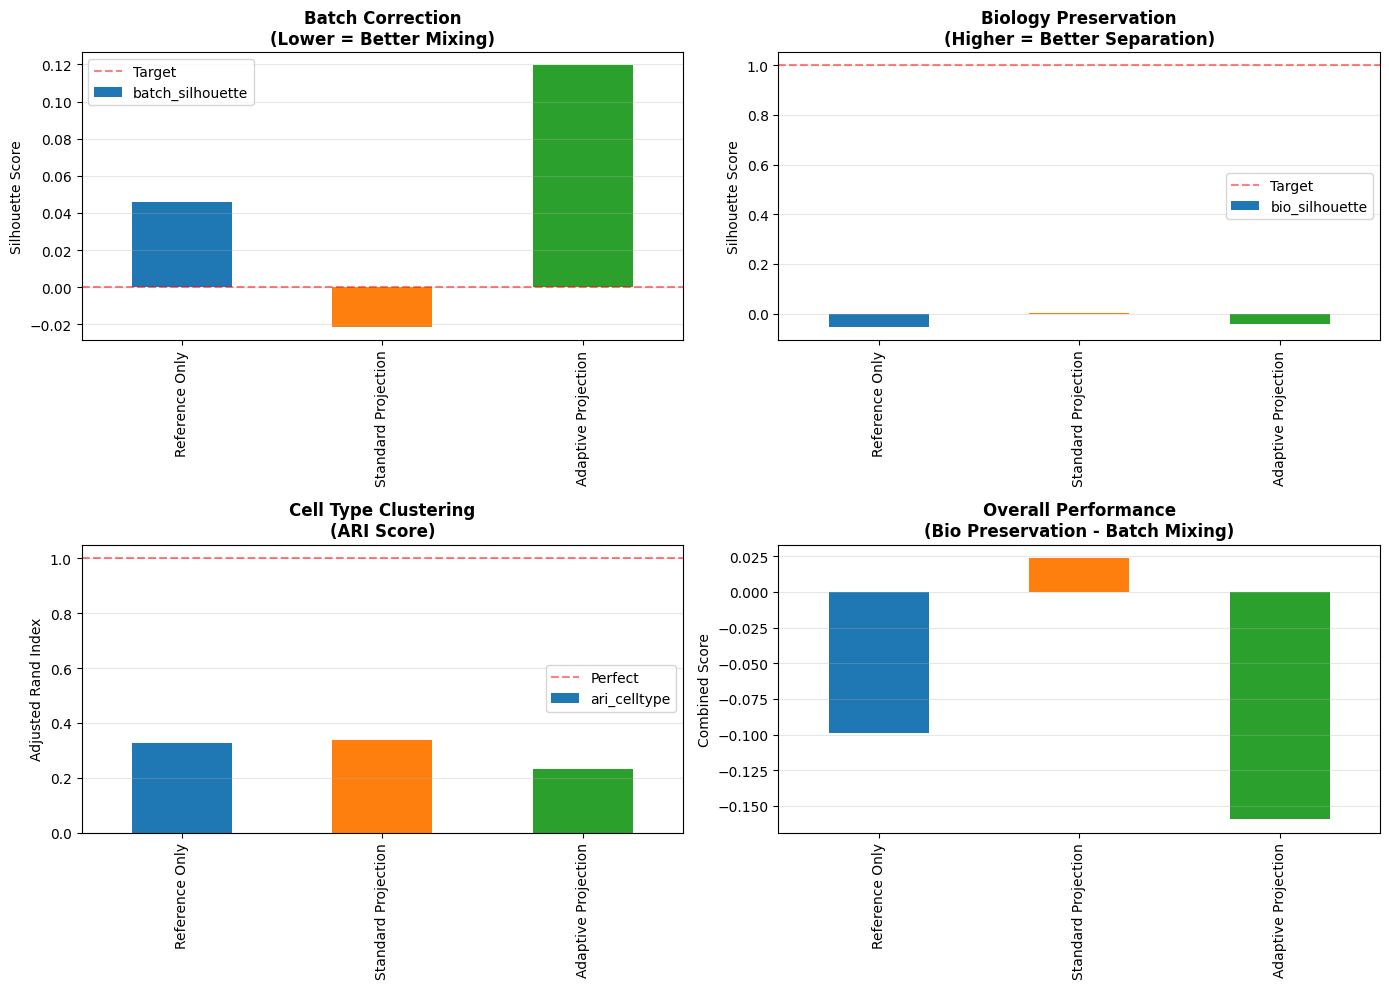


📊 KEY FINDINGS

🔬 Adaptive vs Standard:
   Batch correction improvement: -658.2%
   Biology preservation improvement: -1641.3%

⚠️  Standard projection shows better batch mixing
⚠️  Standard projection shows better biology preservation

💡 Conclusion:
   Standard projection is sufficient for this scenario


In [23]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Batch Correction (lower is better)
ax = axes[0, 0]
metrics_df['batch_silhouette'].plot(kind='bar', ax=ax, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax.set_title('Batch Correction\n(Lower = Better Mixing)', fontsize=12, fontweight='bold')
ax.set_ylabel('Silhouette Score')
ax.set_xlabel('')
ax.axhline(y=0, color='red', linestyle='--', alpha=0.5, label='Target')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Plot 2: Biology Preservation (higher is better)
ax = axes[0, 1]
metrics_df['bio_silhouette'].plot(kind='bar', ax=ax, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax.set_title('Biology Preservation\n(Higher = Better Separation)', fontsize=12, fontweight='bold')
ax.set_ylabel('Silhouette Score')
ax.set_xlabel('')
ax.axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='Target')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Plot 3: Cell Type Clustering (higher is better)
ax = axes[1, 0]
metrics_df['ari_celltype'].plot(kind='bar', ax=ax, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax.set_title('Cell Type Clustering\n(ARI Score)', fontsize=12, fontweight='bold')
ax.set_ylabel('Adjusted Rand Index')
ax.set_xlabel('')
ax.axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='Perfect')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Plot 4: Combined Score (higher is better)
ax = axes[1, 1]
metrics_df['combined_score'].plot(kind='bar', ax=ax, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax.set_title('Overall Performance\n(Bio Preservation - Batch Mixing)', fontsize=12, fontweight='bold')
ax.set_ylabel('Combined Score')
ax.set_xlabel('')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("📊 KEY FINDINGS")
print("="*70)

# Compare standard vs adaptive
standard_batch = metrics_df.loc['Standard Projection', 'batch_silhouette']
adaptive_batch = metrics_df.loc['Adaptive Projection', 'batch_silhouette']
batch_improvement = ((standard_batch - adaptive_batch) / abs(standard_batch)) * 100

standard_bio = metrics_df.loc['Standard Projection', 'bio_silhouette']
adaptive_bio = metrics_df.loc['Adaptive Projection', 'bio_silhouette']
bio_improvement = ((adaptive_bio - standard_bio) / standard_bio) * 100

print(f"\n🔬 Adaptive vs Standard:")
print(f"   Batch correction improvement: {batch_improvement:+.1f}%")
print(f"   Biology preservation improvement: {bio_improvement:+.1f}%")

if adaptive_batch < standard_batch:
    print(f"\n✅ Adaptive projection shows BETTER batch mixing")
else:
    print(f"\n⚠️  Standard projection shows better batch mixing")

if adaptive_bio > standard_bio:
    print(f"✅ Adaptive projection shows BETTER biology preservation")
else:
    print(f"⚠️  Standard projection shows better biology preservation")

print("\n💡 Conclusion:")
if metrics_df.loc['Adaptive Projection', 'combined_score'] > metrics_df.loc['Standard Projection', 'combined_score']:
    print("   Adaptive projection is RECOMMENDED for this domain shift scenario")
else:
    print("   Standard projection is sufficient for this scenario")
print("="*70)

## 🎯 Summary & Recommendations

### Key Takeaways

**Standard Projection** (`transform_query()`)
- ⚡ Ultra-fast: < 1 second
- 🎯 Best for: Similar protocols, speed-critical applications
- ✅ Use when: 10X v2 → 10X v3, same lab batches

**Adaptive Projection** (`transform_query_adaptive()`)
- 🔬 Quality-focused: 1-2 minutes
- 🎯 Best for: Large domain shifts, different technologies
- ✅ Use when: 10X → Smart-seq2, cross-species, different tissues

### Decision Guide

```
Is query protocol very different from reference?
├─ NO  → Use transform_query() (standard)
└─ YES → Is speed critical?
          ├─ YES → Try standard first, use adaptive if poor
          └─ NO  → Use transform_query_adaptive() (adaptive)
```